# Stripe Funnel Analysis

## 1. Load and Preview Data

In [43]:
import pandas as pd
from datetime import datetime

users = pd.read_csv('../data/users.csv')
events = pd.read_csv('../data/events.csv')
transactions = pd.read_csv('../data/transactions.csv')

In [47]:
events['timestamp'] = pd.to_datetime(events['timestamp'])
users['signup_date'] = pd.to_datetime(users['signup_date'])

In [16]:
users.head()

,user_id,signup_date,region,account_type
0,1,2024-02-21,Asia,Business
1,2,2024-01-15,North America,Individual
2,3,2024-03-12,North America,Individual
3,4,2024-03-01,Europe,Individual
4,5,2024-01-21,South America,Business


In [17]:
events.head()

,user_id,event,timestamp
0,1,email_verified,2024-02-22
1,1,business_info_submitted,2024-02-25
2,2,email_verified,2024-01-18
3,3,email_verified,2024-03-13
4,3,business_info_submitted,2024-03-15


In [22]:
transactions.head()

,user_id,payment_date,amount
0,8,2024-03-26,534.87
1,10,2024-04-09,635.22
2,12,2024-01-08,429.61
3,16,2024-04-08,504.48
4,20,2024-03-15,461.42


## 2. Funnel Conversion Overview

In [18]:
funnel_counts = events.groupby('event')['user_id'].nunique().reset_index().sort_values(by='user_id', ascending=False)
funnel_counts.rename(columns={'user_id': 'unique_users'}, inplace=True)
funnel_counts

,event,unique_users
1,email_verified,905
0,business_info_submitted,690
3,kyc_completed,432
2,first_payment,212


## 3. Stage-to-Stage Conversion Rates

In [29]:
stage_order = ['email_verified', 'business_info_submitted', 'kyc_completed', 'first_payment']
conversion = {}

for i in range(1, len(stage_order)):
    prev_stage = stage_order[i-1]
    curr_stage = stage_order[i]

    prev_users = set(events[events['event'] == prev_stage]['user_id'])
    curr_users = set(events[events['event'] == curr_stage]['user_id'])

    rate = len(curr_users & prev_users) / len(prev_users)
    conversion[f"{prev_stage} → {curr_stage}"] = round(rate * 100, 2)

conversion_df = pd.DataFrame(list(conversion.items()), columns=['Stage Transition', 'Conversion Rate (%)'])

## 4. Business Questions & Insights

### Q1: Where is the biggest drop-off the funnel?

In [30]:
conversion_df.sort_values('Conversion Rate (%)')

,Stage Transition,Conversion Rate (%)
2,kyc_completed → first_payment,49.07
1,business_info_submitted → kyc_completed,62.61
0,email_verified → business_info_submitted,76.24


**Insight**: The largest drop-off occurs between 'kyc_completed → first_payment', where only 49.07% of users advance. This suggests KYC may be a friction point in the onboarding process

### Q2: What's the overall signup-to-payment conversion rate?

In [38]:
total_users = users['user_id'].nunique()
paid_users = events[events['event'] == 'first_payment']['user_id'].nunique()
overall_conversion = round((paid_users / total_users) * 100, 2)
print(f"Paid users: {paid_users}")
print(f"Conversion rate: {overall_conversion}%")

Paid users: 212
Conversion rate: 21.2%


**Insight**: Out of the 1,000 users who signed up, only 212 completed a payment - an overall conversion rate of 21.2%. Stripe may be losing over 3/4 its potential users before monetization.

### Q3: How long does it take for users to convert?

In [46]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       1000 non-null   int64 
 1   signup_date   1000 non-null   object
 2   region        1000 non-null   object
 3   account_type  1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


In [51]:
# Time to KYC
kyc_times = events[events['event'] == 'kyc_completed'].merge(users, on='user_id')
kyc_times['days_to_kyc'] = (kyc_times['timestamp'] - kyc_times['signup_date']).dt.days

# Time to payment
pay_times = events[events['event'] == 'first_payment'].merge(users, on='user_id')
pay_times['days_to_payment'] = (pay_times['timestamp'] - pay_times['signup_date']).dt.days

In [53]:
kyc_times['days_to_kyc'].describe()

count    432.000000
mean       7.368056
std        2.006069
min        3.000000
25%        6.000000
50%        7.000000
75%        9.000000
max       12.000000
Name: days_to_kyc, dtype: float64

In [54]:
pay_times['days_to_payment'].describe()

count    212.000000
mean      10.037736
std        2.336297
min        5.000000
25%        8.750000
50%       10.000000
75%       12.000000
max       16.000000
Name: days_to_payment, dtype: float64

**Insight**: On average, users take 7.3 days to complete KYC and 10.0 days to make their first payment. Delays here may be impacting conversion - Stripe could test nudges or reminders at day 3 or day 7 to accelerate progress.

### Q4: Are there differences by region or account type?

In [66]:
# Identify users who made a payment
paid_user_ids = set(events[events['event'] == 'first_payment']['user_id'])

# Create a 'converted' flag in the users table
users['converted'] = users['user_id'].isin(paid_user_ids)

# Conversion by region
region_conv = users.groupby('region')['converted'].mean().round(2) * 100
print(f"Regional conversion rates: {region_conv}")

# Conversion by account type
acct_conv = users.groupby('account_type')['converted'].mean().round(2) * 100
print(f"Account type conversion rates: {acct_conv}")

Regional conversion rates: region
Asia             22.0
Europe           22.0
North America    23.0
South America    17.0
Name: converted, dtype: float64
Account type conversion rates: account_type
Business      23.0
Individual    20.0
Name: converted, dtype: float64


**Insight**:
- Users in North America convert at 23%, while South America is at 17%.
- Business accounts convert at 23%, while Individuals convert at 20%.

These differences suggest regional or onboarding-flow adjustments may be needed to optimize global engagement.

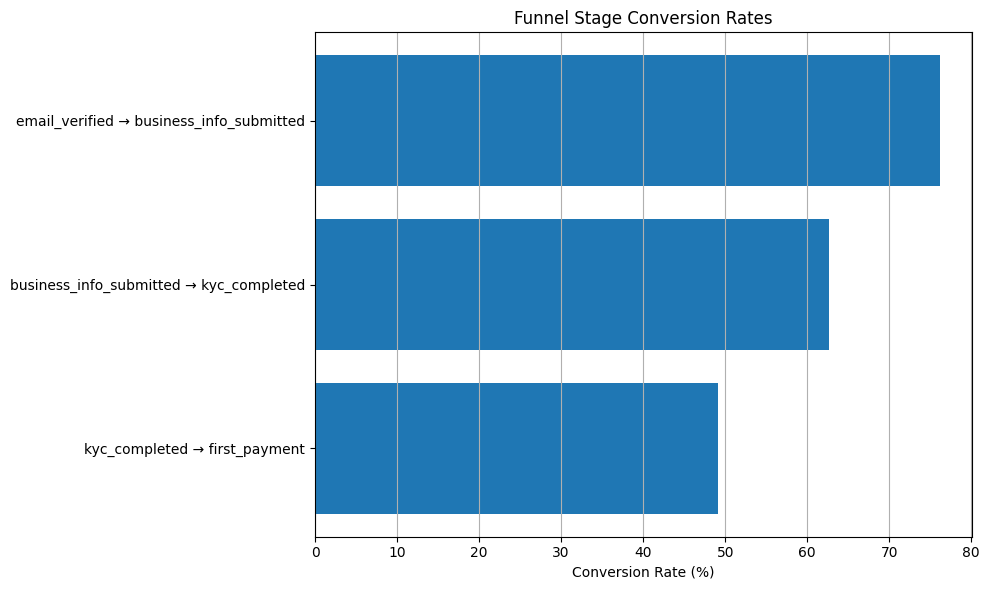

In [ ]:
import matplotlib.pyplot as plt

# Use the conversion dict from earlier
labels = list(conversion.keys())
values = list(conversion.values())

plt.figure(figsize=(10, 6))
plt.barh(labels[::-1], values[::-1])  # Reverse to show top-down
plt.xlabel('Conversion Rate (%)')
plt.title('Funnel Stage Conversion Rates')
plt.grid(axis='x')  
plt.tight_layout()
plt.show()

In [21]:
transactions.head()

,user_id,payment_date,amount
0,8,2024-03-26,534.87
1,10,2024-04-09,635.22
2,12,2024-01-08,429.61
3,16,2024-04-08,504.48
4,20,2024-03-15,461.42
